ref: https://github.com/xuexingyu24/License_Plate_Detection_Pytorch

In [ ]:
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=4bc15369e7812082a64d9a87fbc721b45d08320d15720c76f1115fcd61f634b7
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


## Prepare dataset
url: [VKCV_2022_Contest_02](https://www.kaggle.com/competitions/vkcv2022-contest-02-carplates/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/datasets/carplates.zip .

In [ ]:
%%capture
!unzip carplates.zip

# MTCNN

### PNet Model

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class PNet(nn.Module):

    def __init__(self, is_train=False):

        super(PNet, self).__init__()
        self.is_train = is_train

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d((2,5), ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, (3,5), 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, (3,5), 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4, h', w'].
            a: a float tensor with shape [batch_size, 2, h', w'].
        """
        x = self.features(x)
        a = self.conv4_1(x)
        b = self.conv4_2(x)

        if self.is_train is False:
            a = F.softmax(a, dim=1)

        return b, a

## Onet Model

In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        # without this pretrained model isn't working
        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)
  
class ONet(nn.Module):

    def __init__(self, is_train=False):

        super(ONet, self).__init__()
        self.is_train = is_train

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 1, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1280, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            c: a float tensor with shape [batch_size, 10].
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv6_1(x)
        b = self.conv6_2(x)

        if self.is_train is False:
            a = F.softmax(a, dim=1)

        return b, a

## Utils

In [300]:
def preprocess(img):
    """Preprocessing step before feeding the network.
    Arguments:
        img: a float numpy array of shape [h, w, c].
    Returns:
        a float numpy array of shape [1, c, h, w].
    """
    img = img[:,:,::-1]
    img = np.asarray(img, 'float32')
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5)*0.0078125
    return img

def nms(boxes, overlap_threshold=0.5, mode='union'):
    """Non-maximum suppression.
    Arguments:
        boxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        overlap_threshold: a float number.
        mode: 'union' or 'min'.
    Returns:
        list with indices of the selected boxes
    """

    # if there are no boxes, return the empty list
    if len(boxes) == 0:
        return []

    # list of picked indices
    pick = []

    # grab the coordinates of the bounding boxes
    x1, y1, x2, y2, score = [boxes[:, i] for i in range(5)]

    area = (x2 - x1 + 1.0)*(y2 - y1 + 1.0)
    ids = np.argsort(score)  # in increasing order

    while len(ids) > 0:

        # grab index of the largest value
        last = len(ids) - 1
        i = ids[last]
        pick.append(i)

        # compute intersections
        # of the box with the largest score
        # with the rest of boxes

        # left top corner of intersection boxes
        ix1 = np.maximum(x1[i], x1[ids[:last]])
        iy1 = np.maximum(y1[i], y1[ids[:last]])

        # right bottom corner of intersection boxes
        ix2 = np.minimum(x2[i], x2[ids[:last]])
        iy2 = np.minimum(y2[i], y2[ids[:last]])

        # width and height of intersection boxes
        w = np.maximum(0.0, ix2 - ix1 + 1.0)
        h = np.maximum(0.0, iy2 - iy1 + 1.0)

        # intersections' areas
        inter = w * h
        if mode == 'min':
            overlap = inter/np.minimum(area[i], area[ids[:last]])
        elif mode == 'union':
            # intersection over union (IoU)
            overlap = inter/(area[i] + area[ids[:last]] - inter)

        # delete all boxes where overlap is too big
        ids = np.delete(
            ids,
            np.concatenate([[last], np.where(overlap > overlap_threshold)[0]])
        )

    return pick

def calibrate_box(bboxes, offsets):
    """Transform bounding boxes to be more like true bounding boxes.
    'offsets' is one of the outputs of the nets.
    Arguments:
        bboxes: a float numpy array of shape [n, 5].
        offsets: a float numpy array of shape [n, 4].
    Returns:
        a float numpy array of shape [n, 5].
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    # this is what happening here:
    # tx1, ty1, tx2, ty2 = [offsets[:, i] for i in range(4)]
    # x1_true = x1 + tx1*w
    # y1_true = y1 + ty1*h
    # x2_true = x2 + tx2*w
    # y2_true = y2 + ty2*h
    # below is just more compact form of this

    # are offsets always such that
    # x1 < x2 and y1 < y2 ?

    translation = np.hstack([w, h, w, h])*offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes

def correct_bboxes(bboxes, width, height):
    """Crop boxes that are too big and get coordinates
    with respect to cutouts.
    Arguments:
        bboxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        width: a float number.
        height: a float number.
    Returns:
        dy, dx, edy, edx: a int numpy arrays of shape [n],
            coordinates of the boxes with respect to the cutouts.
        y, x, ey, ex: a int numpy arrays of shape [n],
            corrected ymin, xmin, ymax, xmax.
        h, w: a int numpy arrays of shape [n],
            just heights and widths of boxes.
        in the following order:
            [dy, edy, dx, edx, y, ey, x, ex, w, h].
    """

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    x2,y2 = np.clip(x2, x1, None), np.clip(y2, y1, None)
    w, h = x2 - x1 + 1.0,  y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    # 'e' stands for end
    # (x, y) -> (ex, ey)
    x, y, ex, ey = x1, y1, x2, y2

    # we need to cut out a box from the image.
    # (x, y, ex, ey) are corrected coordinates of the box
    # in the image.
    # (dx, dy, edx, edy) are coordinates of the box in the cutout
    # from the image.
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    # if box's bottom right corner is too far right
    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    # if box's bottom right corner is too low
    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    # if box's top left corner is too far left
    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    # if box's top left corner is too high
    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0

    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


In [ ]:
import numpy.random as npr
import math

def assemble_data(val_file, train_file, anno_file_list=[]):
    #assemble the pos, neg, part annotations to one file

    if len(anno_file_list)==0:
        return 0

    if os.path.exists(val_file):
        os.remove(val_file)
    if os.path.exists(train_file):
        os.remove(train_file)
    
    val_chose_count = 0
    train_chose_count = 0
    
    for anno_file in anno_file_list:
        with open(anno_file, 'r') as f:
            anno_lines = f.readlines()
        base_num = 250000
        if len(anno_lines) > base_num * 3:
            idx_keep = npr.choice(len(anno_lines), size=base_num * 3, replace=True)
        elif len(anno_lines) > 100000:
            idx_keep = npr.choice(len(anno_lines), size=len(anno_lines), replace=True)
        else:
            idx_keep = np.arange(len(anno_lines))
            np.random.shuffle(idx_keep)
        
        num = len(idx_keep)
        val_num = math.ceil(0.2*num)

        val_part = idx_keep[:val_num]
        train_part = idx_keep[val_num:]

        
        with open(val_file, 'a+') as f:
            for idx in val_part:
                # write lables of pos, neg, part images
                f.write(anno_lines[idx])
                val_chose_count+=1
        
        with open(train_file, 'a+') as f:
            for idx in train_part:
                # write lables of pos, neg, part images
                f.write(anno_lines[idx])
                train_chose_count+=1

    print(train_chose_count, val_chose_count)

## Main interface

In [299]:
class MtcnnNet():
  def __init__(self, device, p_model_path=None, o_model_path=None):
    self.device = device
    self.pnet = None
    if p_model_path is not None:
      self.pnet = PNet().to(device)
      self.pnet.load_state_dict(torch.load(p_model_path, map_location=lambda storage, loc: storage))
      self.pnet.eval()

    self.onet = None  
    if o_model_path is not None:
      self.onet = ONet().to(device)
      self.onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
      self.onet.eval()

  def predict(self, image, mini_lp_size):
    bboxes = np.array([])
    if self.pnet is not None:
      bboxes = self.detect_pnet(image, mini_lp_size)
    if self.onet is not None:
      bboxes = self.detect_onet(image, bboxes)
    return bboxes

  def detect_pnet(self, image, min_lp_size):
      # start = time.time()

      thresholds = 0.6 # lp detection thresholds
      nms_thresholds = 0.7

      # BUILD AN IMAGE PYRAMID
      height, width, channel = image.shape
      min_height, min_width = height, width

      factor = 0.707  # sqrt(0.5)

      # scales for scaling the image
      scales = []

      factor_count = 0
      while min_height > min_lp_size[1] and min_width > min_lp_size[0]:
          scales.append(factor ** factor_count)
          min_height *= factor
          min_width *=factor
          factor_count += 1

      # it will be returned
      bounding_boxes = []

      with torch.no_grad():
          # run P-Net on different scales
          for scale in scales:
              sw, sh = math.ceil(width * scale), math.ceil(height * scale)
              img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
              img = torch.FloatTensor(preprocess(img)).to(self.device)
              offset, prob = self.pnet(img)
              probs = prob.cpu().data.numpy()[0, 1, :, :]  # probs: probability of a face at each sliding window
              offsets = offset.cpu().data.numpy()  # offsets: transformations to true bounding boxes
              # applying P-Net is equivalent, in some sense, to moving 12x12 window with stride 2
              stride, cell_size = (2,5), (12,44)
              # indices of boxes where there is probably a lp
              # returns a tuple with an array of row idx's, and an array of col idx's:
              inds = np.where(probs > thresholds)

              if inds[0].size == 0:
                  boxes = None
              else:
                  # transformations of bounding boxes
                  tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
                  offsets = np.array([tx1, ty1, tx2, ty2])
                  score = probs[inds[0], inds[1]]
                  # P-Net is applied to scaled images
                  # so we need to rescale bounding boxes back
                  bounding_box = np.vstack([
                      np.round((stride[1] * inds[1] + 1.0) / scale),
                      np.round((stride[0] * inds[0] + 1.0) / scale),
                      np.round((stride[1] * inds[1] + 1.0 + cell_size[1]) / scale),
                      np.round((stride[0] * inds[0] + 1.0 + cell_size[0]) / scale),
                      score, offsets])
                  boxes = bounding_box.T
                  keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
                  boxes[keep]

              bounding_boxes.append(boxes)

          # collect boxes (and offsets, and scores) from different scales
          bounding_boxes = [i for i in bounding_boxes if i is not None]
          
          if bounding_boxes != []:
              bounding_boxes = np.vstack(bounding_boxes)
              keep = nms(bounding_boxes[:, 0:5], nms_thresholds)
              bounding_boxes = bounding_boxes[keep]
          else:
              bounding_boxes = np.zeros((1,9))
          # use offsets predicted by pnet to transform bounding boxes
          bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
          # shape [n_boxes, 5],  x1, y1, x2, y2, score

          bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

          # print("pnet predicted in {:2.3f} seconds".format(time.time() - start))

          return bboxes

  def detect_onet(self, image, bboxes):

      # start = time.time()

      size = (94,24)
      thresholds = 0.8  # face detection thresholds
      nms_thresholds = 0.7
      height, width, channel = image.shape

      num_boxes = len(bboxes)
      [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

      img_boxes = np.zeros((num_boxes, 3, size[1], size[0]))

      for i in range(num_boxes):
          img_box = np.zeros((h[i], w[i], 3))

          img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
              image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

          # resize
          img_box = cv2.resize(img_box, size, interpolation=cv2.INTER_LINEAR)

          img_boxes[i, :, :, :] = preprocess(img_box)

      img_boxes = torch.FloatTensor(img_boxes).to(self.device)
      offset, prob = self.onet(img_boxes)
      offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
      probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

      keep = np.where(probs[:, 1] > thresholds)[0]
      bboxes = bboxes[keep]
      bboxes[:, 4] = probs[keep, 1].reshape((-1,))  # assign score from stage 2
      offsets = offsets[keep]
      
      bboxes = calibrate_box(bboxes, offsets)
      keep = nms(bboxes, nms_thresholds, mode='min')
      bboxes = bboxes[keep]
      bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
      # print("onet predicted in {:2.3f} seconds".format(time.time() - start))

      return bboxes

In [ ]:
import json 

annotation_path = "/content/data/train.json"
dataset_path = "/content/data"

with open(annotation_path) as f:
    annotation = json.load(f)

## Dataloader

In [ ]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
    def __init__(self, list_path):
        with open(list_path, 'r') as file:
            self.img_files = file.readlines()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):

        annotation = self.img_files[index % len(self.img_files)].strip().split(' ')

        img = cv2.imread(annotation[0])
        img = img[:,:,::-1]
        img = np.asarray(img, 'float32')
        img = img.transpose((2, 0, 1))
        img = (img - 127.5) * 0.0078125
        input_img = torch.FloatTensor(img)

        label = int(annotation[1])
        bbox_target = np.zeros((4,))
        landmark = np.zeros((10,))

        if len(annotation[2:]) == 4:
            bbox_target = np.array(annotation[2:6]).astype(float)
        if len(annotation[2:]) == 14:
            bbox_target = np.array(annotation[2:6]).astype(float)
            landmark = np.array(annotation[6:]).astype(float)

        sample = {'input_img': input_img, 'label': label, 'bbox_target': bbox_target, 'landmark': landmark}

        return sample

## Split dataset on train and test

In [ ]:
import random

cannotation = annotation.copy()
random.shuffle(cannotation)

test_num = math.ceil(len(cannotation)*0.1)
test_annotation = cannotation[:test_num]
train_annotatoin = cannotation[test_num:]

In [ ]:
import json
with open('test_ann.json', 'w') as f:
    json.dump(test_annotation, f)

## PNet

### Prepare dataset

In [ ]:
import sys
import cv2
import random
import os
import numpy as np
from imutils import paths
from tqdm import tqdm

In [ ]:
def IoU(box, boxes):
    """Compute IoU between detect box and gt boxes
    Parameters:
    ----------
    box: numpy array , shape (5, ): x1, y1, x2, y2, score
        input box
    boxes: numpy array, shape (n, 4): x1, y1, x2, y2
        input ground truth boxes
    Returns:
    -------
    ovr: numpy.array, shape (n, )
        IoU
    """
    # box = (x1, y1, x2, y2)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    # abtain the offset of the interception of union between crop_box and gt_box
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [ ]:
pos_save_dir = "/content/train/pnet/positive"
part_save_dir = "/content/train/pnet/part"
neg_save_dir = "/content/train/pnet/negative"

pos_save_txt = '/content/train/pnet/pos.txt'
neg_save_txt = '/content/train/pnet/neg.txt'
part_save_txt = '/content/train/pnet/part.txt'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)
    
# store labels of positive, negative, part images
f1 = open(pos_save_txt, 'w')
f2 = open(neg_save_txt, 'w')
f3 = open(part_save_txt, 'w')

num = len(train_annotatoin)
print("%d pics in total" % num)

p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0

23069 pics in total


In [ ]:
for img_info in tqdm(train_annotatoin):
    im_path = f'{dataset_path}/{img_info["file"]}'

    nums = len(img_info['nums'])
    boxes = np.zeros((nums,4), dtype=np.int32)

    for i, plate in enumerate(img_info['nums']):
      bb = np.array(plate['box'])
      x1, y1, x2, y2 = min(bb[:, 0]), min(bb[:, 1]), max(bb[:, 0]), max(bb[:, 1])
      boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3] = x1, y1, x2, y2
    
    img = cv2.imread(im_path)
    idx += 1

    if img is None:
      continue

    height, width, channel = img.shape
    
    neg_num = 0
    while neg_num < 35:
        size_x = np.random.randint(47, min(width, height) / 2)
        size_y = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size_x)
        ny = np.random.randint(0, height - size_y)
        crop_box = np.array([nx, ny, nx + size_x, ny + size_y])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size_y, nx: nx + size_x, :]
        resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1
            
    for box in boxes:
        # box (x_left, y_top, w, h)
        x1, y1, x2, y2 = box
        w = x2 - x1 + 1
        h = y2 - y1 + 1

        # generate negative examples that have overlap with gt
        for i in range(5):
            size_x = np.random.randint(47, min(width, height) / 2)
            size_y = np.random.randint(12, min(width, height) / 2)
            # delta_x and delta_y are offsets of (x1, y1)
            delta_x = np.random.randint(max(-size_x, -x1), w)
            delta_y = np.random.randint(max(-size_y, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size_x > width or ny1 + size_y > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size_x, ny1 + size_y])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size_y, nx1: nx1 + size_x, :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
        # generate positive examples and part faces
        for i in range(20):
            size_x = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
            size_y = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size_x / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size_y / 2, 0)
            nx2 = nx1 + size_x
            ny2 = ny1 + size_y

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size_x)
            offset_y1 = (y1 - ny1) / float(size_y)
            offset_x2 = (x2 - nx2) / float(size_x)
            offset_y2 = (y2 - ny2) / float(size_y)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
            elif IoU(crop_box, box_) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1

print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

100%|██████████| 23069/23069 [12:03<00:00, 31.87it/s]

23069 images done, pos: 25952 part: 31144 neg: 911926


In [ ]:
f1.close()
f2.close()
f3.close()

In [ ]:
# !rm -rf /content/train

In [ ]:
val_path='/content/train/pnet/val_imglist.txt'
train_path='/content/train/pnet/train_imglist.txt'

anno_list = []

anno_list.append(pos_save_txt)
anno_list.append(neg_save_txt)
anno_list.append(part_save_txt)

chose_count = assemble_data(val_path, train_path, anno_list)

645676 161420


In [ ]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
    def __init__(self, list_path):
        with open(list_path, 'r') as file:
            self.img_files = file.readlines()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):

        annotation = self.img_files[index % len(self.img_files)].strip().split(' ')

        img = cv2.imread(annotation[0])
        img = img[:,:,::-1]
        img = np.asarray(img, 'float32')
        img = img.transpose((2, 0, 1))
        img = (img - 127.5) * 0.0078125
        input_img = torch.FloatTensor(img)

        label = int(annotation[1])
        bbox_target = np.zeros((4,))
        landmark = np.zeros((10,))

        if len(annotation[2:]) == 4:
            bbox_target = np.array(annotation[2:6]).astype(float)
        if len(annotation[2:]) == 14:
            bbox_target = np.array(annotation[2:6]).astype(float)
            landmark = np.array(annotation[6:]).astype(float)

        sample = {'input_img': input_img, 'label': label, 'bbox_target': bbox_target, 'landmark': landmark}

        return sample

### Create model

In [ ]:
import copy
import time
from tqdm import tqdm
from datetime import datetime  

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)

In [ ]:
batch_size = 1024
dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(train_path), batch_size=batch_size, shuffle=True),
               'val': torch.utils.data.DataLoader(ListDataset(val_path), batch_size=batch_size, shuffle=True)}

In [ ]:
dataset_sizes = {'train': len(ListDataset(train_path)), 'val': len(ListDataset(val_path))}
print('training dataset loaded with length : {}'.format(len(ListDataset(train_path))))
print('validation dataset loaded with length : {}'.format(len(ListDataset(val_path))))

training dataset loaded with length : 645676
validation dataset loaded with length : 161420


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# load the model and weights for initialization
model = PNet(is_train=True).to(device)
model.apply(weights_init)

PNet(
  (features): Sequential(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=(2, 5), stride=(2, 5), padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 5), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 5), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
  )
  (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
train_logging_file = '/content/train/pnet/train_logging.txt'

optimizer = torch.optim.Adam(model.parameters())
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
best_loss = 100

loss_cls = nn.CrossEntropyLoss()
loss_offset = nn.MSELoss()

### Train model

In [ ]:
num_epochs = 16

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set model to training mode
        else:
            model.eval()  # set model to evaluate mode

        running_loss, running_loss_cls, running_loss_offset = 0.0, 0.0, 0.0
        running_correct = 0.0
        running_gt = 0.0

        # iterate over data
        for i_batch, sample_batched in enumerate(tqdm(dataloaders[phase])):

            input_images, gt_label, gt_offset = sample_batched['input_img'], \
                                                sample_batched['label'], \
                                                sample_batched['bbox_target']
            input_images = input_images.to(device)
            gt_label = gt_label.to(device)
            # print('gt_label is ', gt_label)
            gt_offset = gt_offset.type(torch.FloatTensor).to(device)
            # print('gt_offset shape is ',gt_offset.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                pred_offsets, pred_label = model(input_images)
                pred_offsets = torch.squeeze(pred_offsets)
                pred_label = torch.squeeze(pred_label)
                # calculate the cls loss
                # get the mask element which >= 0, only 0 and 1 can effect the detection loss
                mask_cls = torch.ge(gt_label, 0)
                valid_gt_label = gt_label[mask_cls]
                valid_pred_label = pred_label[mask_cls]

                # calculate the box loss
                # get the mask element which != 0
                unmask = torch.eq(gt_label, 0)
                mask_offset = torch.eq(unmask, 0)
                valid_gt_offset = gt_offset[mask_offset]
                valid_pred_offset = pred_offsets[mask_offset]

                loss = torch.tensor(0.0).to(device)
                cls_loss, offset_loss = 0.0, 0.0
                eval_correct = 0.0
                num_gt = len(valid_gt_label)

                if len(valid_gt_label) != 0:
                    loss += 0.02*loss_cls(valid_pred_label, valid_gt_label)
                    cls_loss = loss_cls(valid_pred_label, valid_gt_label).item()
                    pred = torch.max(valid_pred_label, 1)[1]
                    eval_correct = (pred == valid_gt_label).sum().item()

                if len(valid_gt_offset) != 0:
                    loss += 0.6*loss_offset(valid_pred_offset, valid_gt_offset)
                    offset_loss = loss_offset(valid_pred_offset, valid_gt_offset).item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()*batch_size
                running_loss_cls += cls_loss*batch_size
                running_loss_offset += offset_loss*batch_size
                running_correct += eval_correct
                running_gt += num_gt

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_loss_cls = running_loss_cls / dataset_sizes[phase]
        epoch_loss_offset = running_loss_offset / dataset_sizes[phase]
        epoch_accuracy = running_correct / (running_gt + 1e-16)

        print('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
              .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset))
        with open(train_logging_file, 'a') as f:
            f.write('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
                    .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset)+'\n')
        f.close()

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best loss: {:4f}'.format(best_loss))

Epoch 0/15
----------


100%|██████████| 631/631 [06:22<00:00,  1.65it/s]


train Loss: 0.0122 accuracy: 0.9609 cls Loss: 0.1263 offset Loss: 0.0161


100%|██████████| 158/158 [01:06<00:00,  2.38it/s]


val Loss: 0.0083 accuracy: 0.9781 cls Loss: 0.0669 offset Loss: 0.0116
Epoch 1/15
----------


100%|██████████| 631/631 [01:17<00:00,  8.13it/s]


train Loss: 0.0074 accuracy: 0.9807 cls Loss: 0.0580 offset Loss: 0.0104


100%|██████████| 158/158 [00:15<00:00, 10.17it/s]


val Loss: 0.0068 accuracy: 0.9829 cls Loss: 0.0501 offset Loss: 0.0097
Epoch 2/15
----------


100%|██████████| 631/631 [01:07<00:00,  9.40it/s]


train Loss: 0.0063 accuracy: 0.9857 cls Loss: 0.0433 offset Loss: 0.0091


100%|██████████| 158/158 [00:16<00:00,  9.53it/s]


val Loss: 0.0063 accuracy: 0.9879 cls Loss: 0.0369 offset Loss: 0.0092
Epoch 3/15
----------


100%|██████████| 631/631 [01:16<00:00,  8.25it/s]


train Loss: 0.0056 accuracy: 0.9897 cls Loss: 0.0317 offset Loss: 0.0083


100%|██████████| 158/158 [00:17<00:00,  9.18it/s]


val Loss: 0.0054 accuracy: 0.9919 cls Loss: 0.0266 offset Loss: 0.0082
Epoch 4/15
----------


100%|██████████| 631/631 [01:08<00:00,  9.17it/s]


train Loss: 0.0051 accuracy: 0.9923 cls Loss: 0.0245 offset Loss: 0.0077


100%|██████████| 158/158 [00:16<00:00,  9.38it/s]


val Loss: 0.0049 accuracy: 0.9935 cls Loss: 0.0210 offset Loss: 0.0075
Epoch 5/15
----------


100%|██████████| 631/631 [01:12<00:00,  8.67it/s]


train Loss: 0.0048 accuracy: 0.9935 cls Loss: 0.0210 offset Loss: 0.0073


100%|██████████| 158/158 [00:15<00:00,  9.99it/s]


val Loss: 0.0048 accuracy: 0.9938 cls Loss: 0.0189 offset Loss: 0.0074
Epoch 6/15
----------


100%|██████████| 631/631 [01:12<00:00,  8.74it/s]


train Loss: 0.0046 accuracy: 0.9942 cls Loss: 0.0187 offset Loss: 0.0070


100%|██████████| 158/158 [00:17<00:00,  8.88it/s]


val Loss: 0.0048 accuracy: 0.9945 cls Loss: 0.0176 offset Loss: 0.0074
Epoch 7/15
----------


100%|██████████| 631/631 [01:16<00:00,  8.29it/s]


train Loss: 0.0044 accuracy: 0.9947 cls Loss: 0.0173 offset Loss: 0.0068


100%|██████████| 158/158 [00:17<00:00,  8.84it/s]


val Loss: 0.0044 accuracy: 0.9947 cls Loss: 0.0166 offset Loss: 0.0067
Epoch 8/15
----------


100%|██████████| 631/631 [01:12<00:00,  8.70it/s]


train Loss: 0.0042 accuracy: 0.9951 cls Loss: 0.0160 offset Loss: 0.0065


100%|██████████| 158/158 [00:17<00:00,  9.07it/s]


val Loss: 0.0045 accuracy: 0.9950 cls Loss: 0.0158 offset Loss: 0.0069
Epoch 9/15
----------


100%|██████████| 631/631 [01:10<00:00,  8.94it/s]


train Loss: 0.0041 accuracy: 0.9954 cls Loss: 0.0149 offset Loss: 0.0064


100%|██████████| 158/158 [00:19<00:00,  8.18it/s]


val Loss: 0.0042 accuracy: 0.9961 cls Loss: 0.0140 offset Loss: 0.0065
Epoch 10/15
----------


100%|██████████| 631/631 [01:08<00:00,  9.28it/s]


train Loss: 0.0040 accuracy: 0.9957 cls Loss: 0.0142 offset Loss: 0.0062


100%|██████████| 158/158 [00:16<00:00,  9.70it/s]


val Loss: 0.0042 accuracy: 0.9960 cls Loss: 0.0132 offset Loss: 0.0065
Epoch 11/15
----------


100%|██████████| 631/631 [01:09<00:00,  9.13it/s]


train Loss: 0.0039 accuracy: 0.9961 cls Loss: 0.0134 offset Loss: 0.0061


100%|██████████| 158/158 [00:16<00:00,  9.56it/s]


val Loss: 0.0041 accuracy: 0.9962 cls Loss: 0.0129 offset Loss: 0.0064
Epoch 12/15
----------


100%|██████████| 631/631 [01:12<00:00,  8.76it/s]


train Loss: 0.0039 accuracy: 0.9961 cls Loss: 0.0129 offset Loss: 0.0060


100%|██████████| 158/158 [00:16<00:00,  9.83it/s]


val Loss: 0.0040 accuracy: 0.9963 cls Loss: 0.0122 offset Loss: 0.0062
Epoch 13/15
----------


100%|██████████| 631/631 [01:09<00:00,  9.04it/s]


train Loss: 0.0038 accuracy: 0.9963 cls Loss: 0.0124 offset Loss: 0.0059


100%|██████████| 158/158 [00:16<00:00,  9.80it/s]


val Loss: 0.0039 accuracy: 0.9967 cls Loss: 0.0114 offset Loss: 0.0061
Epoch 14/15
----------


100%|██████████| 631/631 [01:11<00:00,  8.87it/s]


train Loss: 0.0037 accuracy: 0.9966 cls Loss: 0.0119 offset Loss: 0.0058


100%|██████████| 158/158 [00:16<00:00,  9.66it/s]


val Loss: 0.0039 accuracy: 0.9963 cls Loss: 0.0127 offset Loss: 0.0061
Epoch 15/15
----------


100%|██████████| 631/631 [01:09<00:00,  9.02it/s]


train Loss: 0.0037 accuracy: 0.9967 cls Loss: 0.0113 offset Loss: 0.0057


100%|██████████| 158/158 [00:18<00:00,  8.55it/s]

val Loss: 0.0039 accuracy: 0.9966 cls Loss: 0.0116 offset Loss: 0.0061
Training complete in 29m 41s
Best loss: 0.003905


### Save model path

In [ ]:
model.load_state_dict(best_model_wts)

date_time = datetime.now()
pnet_save_model_path = date_time.strftime(f"/content/train/pnet/pnet-%H-%M-%S.pth")

torch.save(model.state_dict(), pnet_save_model_path)

In [ ]:
!cp $pnet_save_model_path /content/drive/MyDrive/task/licence_plate
!cp /content/train/pnet/train_logging.txt /content/drive/MyDrive/task/licence_plate/pnet_train_logging.txt

## Onet

### Prepare dataset

In [ ]:
import sys
import cv2
import random
import os
import numpy as np
from imutils import paths
from tqdm import tqdm

In [ ]:
pos_save_dir = "/content/train/onet/positive"
part_save_dir = "/content/train/onet/part"
neg_save_dir = "/content/train/onet/negative"

pos_save_txt = '/content/train/onet/pos.txt'
neg_save_txt = '/content/train/onet/neg.txt'
part_save_txt = '/content/train/onet/part.txt'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)
    
# store labels of positive, negative, part images
f1 = open(pos_save_txt, 'w')
f2 = open(neg_save_txt, 'w')
f3 = open(part_save_txt, 'w')

num = len(train_annotatoin)
print("%d pics in total" % num)

image_size = (94, 24)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0

23069 pics in total


In [ ]:
# !rm -rf /content/train/onet

In [ ]:
mtcnn = MtcnnNet(device, p_model_path=pnet_save_model_path)

PNet(
  (features): Sequential(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=(2, 5), stride=(2, 5), padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 5), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 5), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
  )
  (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
) None


In [ ]:
for j, img_info in enumerate(tqdm(train_annotatoin)):
    im_path = f'{dataset_path}/{img_info["file"]}'

    nums = len(img_info['nums'])
    boxes = np.zeros((nums,4), dtype=np.int32)

    for i, plate in enumerate(img_info['nums']):
      bb = np.array(plate['box'])
      x1, y1, x2, y2 = min(bb[:, 0]), min(bb[:, 1]), max(bb[:, 0]), max(bb[:, 1])
      boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3] = x1, y1, x2, y2
    
    image = cv2.imread(im_path)

    if image is None:
      continue

    bboxes = mtcnn.predict(image, (50, 15))

    dets = np.round(bboxes[:, 0:4])
    img = cv2.imread(im_path)
    idx += 1

    height, width, channel = img.shape

    for box in dets:
        x_left, y_top, x_right, y_bottom = box[0:4].astype(int)
        width = x_right - x_left + 1
        height = y_bottom - y_top + 1

        # ignore box that is too small or beyond image border
        if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
            continue

        # compute intersection over union(IoU) between current box and all gt boxes
        Iou = IoU(box, boxes)
        cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
        resized_im = cv2.resize(cropped_im, image_size, interpolation=cv2.INTER_LINEAR)

        # save negative images and write label
        if np.max(Iou) < 0.3 and n_idx < 3.2*p_idx+1:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
        else:
            # find gt_box with the highest iou
            idx_Iou = np.argmax(Iou)
            assigned_gt = boxes[idx_Iou]
            x1, y1, x2, y2 = assigned_gt

            # compute bbox reg label
            offset_x1 = (x1 - x_left) / float(width)
            offset_y1 = (y1 - y_top) / float(height)
            offset_x2 = (x2 - x_right) / float(width)
            offset_y2 = (y2 - y_bottom) / float(height)

            # save positive and part-face images and write labels
            if np.max(Iou) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1

            elif np.max(Iou) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1
    if j % 1000 == 0:
        print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

  0%|          | 1/23069 [00:00<1:14:50,  5.14it/s]

1 images done, pos: 8 part: 11 neg: 27


  4%|▍         | 1001/23069 [02:01<47:56,  7.67it/s]

1001 images done, pos: 8309 part: 6820 neg: 26590


  9%|▊         | 2000/23069 [04:00<36:11,  9.70it/s]

2001 images done, pos: 16668 part: 13816 neg: 53291


 13%|█▎        | 3001/23069 [05:59<53:15,  6.28it/s]

3001 images done, pos: 24936 part: 21123 neg: 79797


 17%|█▋        | 4001/23069 [08:03<1:01:43,  5.15it/s]

4001 images done, pos: 33366 part: 28059 neg: 106764


 22%|██▏       | 5002/23069 [10:24<39:20,  7.65it/s]

5001 images done, pos: 41982 part: 35231 neg: 134321


 26%|██▌       | 6002/23069 [12:29<19:44, 14.41it/s]

6001 images done, pos: 50417 part: 42304 neg: 161198


 30%|███       | 7002/23069 [14:36<21:35, 12.40it/s]

7001 images done, pos: 58949 part: 49594 neg: 188522


 35%|███▍      | 8001/23069 [16:43<23:48, 10.55it/s]

8001 images done, pos: 67321 part: 56495 neg: 215369


 39%|███▉      | 9000/23069 [18:52<29:24,  7.97it/s]

9001 images done, pos: 75414 part: 63481 neg: 241279


 43%|████▎     | 10003/23069 [21:06<32:55,  6.61it/s]

10001 images done, pos: 83813 part: 70471 neg: 268198


 48%|████▊     | 11002/23069 [23:18<31:01,  6.48it/s]

11001 images done, pos: 92224 part: 77569 neg: 295116


 52%|█████▏    | 12002/23069 [25:31<27:27,  6.72it/s]

12001 images done, pos: 100884 part: 84637 neg: 322830


 56%|█████▋    | 13002/23069 [27:46<29:46,  5.63it/s]

13001 images done, pos: 109374 part: 91601 neg: 349998


 61%|██████    | 14002/23069 [30:05<15:26,  9.79it/s]

14001 images done, pos: 118181 part: 98581 neg: 378162


 65%|██████▌   | 15001/23069 [32:21<30:18,  4.44it/s]

15001 images done, pos: 126682 part: 105730 neg: 405347


 69%|██████▉   | 16002/23069 [34:33<16:46,  7.02it/s]

16001 images done, pos: 135422 part: 112758 neg: 433352


 74%|███████▎  | 17003/23069 [36:43<14:10,  7.13it/s]

17001 images done, pos: 143959 part: 119644 neg: 460667


 78%|███████▊  | 18000/23069 [39:00<09:06,  9.27it/s]

18000 images done, pos: 152490 part: 126803 neg: 487969


 82%|████████▏ | 19002/23069 [41:10<08:17,  8.18it/s]

19000 images done, pos: 161002 part: 133704 neg: 515111


 87%|████████▋ | 20001/23069 [43:25<06:32,  7.82it/s]

20000 images done, pos: 169537 part: 140580 neg: 542520


 91%|█████████ | 21001/23069 [45:35<05:28,  6.30it/s]

21000 images done, pos: 177790 part: 147538 neg: 568910


 95%|█████████▌| 22002/23069 [47:43<01:41, 10.49it/s]

22000 images done, pos: 186155 part: 154476 neg: 595632


100%|█████████▉| 23003/23069 [50:00<00:08,  7.66it/s]

23000 images done, pos: 194839 part: 161281 neg: 623466


100%|██████████| 23069/23069 [50:08<00:00,  7.67it/s]


In [ ]:
f1.close()
f2.close()
f3.close()

In [ ]:
# !rm -rf /content/train

In [ ]:
val_path='/content/train/onet/val_imglist.txt'
train_path='/content/train/onet/train_imglist.txt'

anno_list = []

anno_list.append(pos_save_txt)
anno_list.append(neg_save_txt)
anno_list.append(part_save_txt)

chose_count = assemble_data(val_path, train_path, anno_list)

786150 196540


### Create model

In [ ]:
import copy
import time
from tqdm import tqdm
from datetime import datetime  

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)

In [ ]:
batch_size = 1024
dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(train_path), batch_size=batch_size, shuffle=True),
               'val': torch.utils.data.DataLoader(ListDataset(val_path), batch_size=batch_size, shuffle=True)}

In [ ]:
dataset_sizes = {'train': len(ListDataset(train_path)), 'val': len(ListDataset(val_path))}
print('training dataset loaded with length : {}'.format(len(ListDataset(train_path))))
print('validation dataset loaded with length : {}'.format(len(ListDataset(val_path))))

training dataset loaded with length : 786150
validation dataset loaded with length : 196540


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# load the model and weights for initialization
model = ONet(is_train=True).to(device)
model.apply(weights_init)

ONet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=32)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=64)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=64)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (prelu4): PReLU(num_parameters=128)
    (flatten): Flatten()
    (conv5): Linear(in_features=1280, out_features=256, bias=True)
    (drop5): Dropout(p=0.25, inplace=False)
    (prelu5): PReLU(num_parameters=256)
  )
  (conv6_1): Linear(in_features=256, out_features=2, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, b

In [ ]:
train_logging_file = '/content/train/onet/train_logging.txt'

optimizer = torch.optim.Adam(model.parameters())
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
best_loss = 100

loss_cls = nn.CrossEntropyLoss()
loss_offset = nn.MSELoss()

### Train model

In [ ]:
num_epochs = 16

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set model to training mode
        else:
            model.eval()  # set model to evaluate mode

        running_loss, running_loss_cls, running_loss_offset = 0.0, 0.0, 0.0
        running_correct = 0.0
        running_gt = 0.0

        # iterate over data
        for i_batch, sample_batched in enumerate(tqdm(dataloaders[phase])):

            input_images, gt_label, gt_offset = sample_batched['input_img'], \
                                                sample_batched['label'], \
                                                sample_batched['bbox_target']
            input_images = input_images.to(device)
            gt_label = gt_label.to(device)
            # print('gt_label is ', gt_label)
            gt_offset = gt_offset.type(torch.FloatTensor).to(device)
            # print('gt_offset shape is ',gt_offset.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                pred_offsets, pred_label = model(input_images)
                pred_offsets = torch.squeeze(pred_offsets)
                pred_label = torch.squeeze(pred_label)
                # calculate the cls loss
                # get the mask element which >= 0, only 0 and 1 can effect the detection loss
                mask_cls = torch.ge(gt_label, 0)
                valid_gt_label = gt_label[mask_cls]
                valid_pred_label = pred_label[mask_cls]

                # calculate the box loss
                # get the mask element which != 0
                unmask = torch.eq(gt_label, 0)
                mask_offset = torch.eq(unmask, 0)
                valid_gt_offset = gt_offset[mask_offset]
                valid_pred_offset = pred_offsets[mask_offset]

                loss = torch.tensor(0.0).to(device)
                cls_loss, offset_loss = 0.0, 0.0
                eval_correct = 0.0
                num_gt = len(valid_gt_label)

                if len(valid_gt_label) != 0:
                    loss += 0.02*loss_cls(valid_pred_label, valid_gt_label)
                    cls_loss = loss_cls(valid_pred_label, valid_gt_label).item()
                    pred = torch.max(valid_pred_label, 1)[1]
                    eval_correct = (pred == valid_gt_label).sum().item()

                if len(valid_gt_offset) != 0:
                    loss += 0.6*loss_offset(valid_pred_offset, valid_gt_offset)
                    offset_loss = loss_offset(valid_pred_offset, valid_gt_offset).item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()*batch_size
                running_loss_cls += cls_loss*batch_size
                running_loss_offset += offset_loss*batch_size
                running_correct += eval_correct
                running_gt += num_gt

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_loss_cls = running_loss_cls / dataset_sizes[phase]
        epoch_loss_offset = running_loss_offset / dataset_sizes[phase]
        epoch_accuracy = running_correct / (running_gt + 1e-16)

        print('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
              .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset))
        with open(train_logging_file, 'a') as f:
            f.write('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
                    .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset)+'\n')
        f.close()

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best loss: {:4f}'.format(best_loss))

Epoch 0/15
----------


100%|██████████| 768/768 [09:32<00:00,  1.34it/s]


train Loss: 0.0129 accuracy: 0.9142 cls Loss: 0.2045 offset Loss: 0.0147


100%|██████████| 192/192 [01:38<00:00,  1.96it/s]


val Loss: 0.0044 accuracy: 0.9823 cls Loss: 0.0579 offset Loss: 0.0054
Epoch 1/15
----------


100%|██████████| 768/768 [03:34<00:00,  3.58it/s]


train Loss: 0.0042 accuracy: 0.9848 cls Loss: 0.0510 offset Loss: 0.0053


100%|██████████| 192/192 [00:40<00:00,  4.70it/s]


val Loss: 0.0034 accuracy: 0.9872 cls Loss: 0.0425 offset Loss: 0.0042
Epoch 2/15
----------


100%|██████████| 768/768 [03:08<00:00,  4.07it/s]


train Loss: 0.0033 accuracy: 0.9880 cls Loss: 0.0410 offset Loss: 0.0042


100%|██████████| 192/192 [00:40<00:00,  4.80it/s]


val Loss: 0.0029 accuracy: 0.9873 cls Loss: 0.0410 offset Loss: 0.0035
Epoch 3/15
----------


100%|██████████| 768/768 [03:07<00:00,  4.10it/s]


train Loss: 0.0029 accuracy: 0.9893 cls Loss: 0.0361 offset Loss: 0.0037


100%|██████████| 192/192 [00:40<00:00,  4.77it/s]


val Loss: 0.0025 accuracy: 0.9900 cls Loss: 0.0336 offset Loss: 0.0030
Epoch 4/15
----------


100%|██████████| 768/768 [03:06<00:00,  4.13it/s]


train Loss: 0.0027 accuracy: 0.9902 cls Loss: 0.0326 offset Loss: 0.0034


100%|██████████| 192/192 [00:40<00:00,  4.78it/s]


val Loss: 0.0025 accuracy: 0.9899 cls Loss: 0.0332 offset Loss: 0.0030
Epoch 5/15
----------


100%|██████████| 768/768 [03:03<00:00,  4.18it/s]


train Loss: 0.0025 accuracy: 0.9908 cls Loss: 0.0302 offset Loss: 0.0032


100%|██████████| 192/192 [00:42<00:00,  4.50it/s]


val Loss: 0.0022 accuracy: 0.9915 cls Loss: 0.0289 offset Loss: 0.0027
Epoch 6/15
----------


100%|██████████| 768/768 [03:06<00:00,  4.11it/s]


train Loss: 0.0024 accuracy: 0.9915 cls Loss: 0.0278 offset Loss: 0.0030


100%|██████████| 192/192 [00:40<00:00,  4.79it/s]


val Loss: 0.0022 accuracy: 0.9915 cls Loss: 0.0275 offset Loss: 0.0027
Epoch 7/15
----------


100%|██████████| 768/768 [03:05<00:00,  4.13it/s]


train Loss: 0.0022 accuracy: 0.9920 cls Loss: 0.0257 offset Loss: 0.0029


100%|██████████| 192/192 [00:39<00:00,  4.81it/s]


val Loss: 0.0020 accuracy: 0.9917 cls Loss: 0.0260 offset Loss: 0.0025
Epoch 8/15
----------


100%|██████████| 768/768 [03:05<00:00,  4.14it/s]


train Loss: 0.0021 accuracy: 0.9927 cls Loss: 0.0234 offset Loss: 0.0028


100%|██████████| 192/192 [00:39<00:00,  4.86it/s]


val Loss: 0.0020 accuracy: 0.9920 cls Loss: 0.0253 offset Loss: 0.0024
Epoch 9/15
----------


100%|██████████| 768/768 [03:09<00:00,  4.05it/s]


train Loss: 0.0020 accuracy: 0.9931 cls Loss: 0.0216 offset Loss: 0.0027


100%|██████████| 192/192 [00:39<00:00,  4.82it/s]


val Loss: 0.0019 accuracy: 0.9928 cls Loss: 0.0225 offset Loss: 0.0025
Epoch 10/15
----------


100%|██████████| 768/768 [03:05<00:00,  4.13it/s]


train Loss: 0.0020 accuracy: 0.9936 cls Loss: 0.0198 offset Loss: 0.0026


100%|██████████| 192/192 [00:39<00:00,  4.80it/s]


val Loss: 0.0019 accuracy: 0.9933 cls Loss: 0.0217 offset Loss: 0.0025
Epoch 11/15
----------


100%|██████████| 768/768 [03:14<00:00,  3.94it/s]


train Loss: 0.0019 accuracy: 0.9940 cls Loss: 0.0182 offset Loss: 0.0026


100%|██████████| 192/192 [00:40<00:00,  4.72it/s]


val Loss: 0.0020 accuracy: 0.9933 cls Loss: 0.0219 offset Loss: 0.0026
Epoch 12/15
----------


100%|██████████| 768/768 [03:06<00:00,  4.11it/s]


train Loss: 0.0018 accuracy: 0.9946 cls Loss: 0.0159 offset Loss: 0.0025


100%|██████████| 192/192 [00:44<00:00,  4.36it/s]


val Loss: 0.0018 accuracy: 0.9936 cls Loss: 0.0196 offset Loss: 0.0024
Epoch 13/15
----------


100%|██████████| 768/768 [03:06<00:00,  4.11it/s]


train Loss: 0.0018 accuracy: 0.9950 cls Loss: 0.0147 offset Loss: 0.0025


100%|██████████| 192/192 [00:39<00:00,  4.84it/s]


val Loss: 0.0018 accuracy: 0.9941 cls Loss: 0.0187 offset Loss: 0.0024
Epoch 14/15
----------


100%|██████████| 768/768 [03:05<00:00,  4.15it/s]


train Loss: 0.0017 accuracy: 0.9956 cls Loss: 0.0127 offset Loss: 0.0024


100%|██████████| 192/192 [00:39<00:00,  4.82it/s]


val Loss: 0.0017 accuracy: 0.9946 cls Loss: 0.0175 offset Loss: 0.0023
Epoch 15/15
----------


100%|██████████| 768/768 [03:06<00:00,  4.12it/s]


train Loss: 0.0017 accuracy: 0.9962 cls Loss: 0.0112 offset Loss: 0.0024


100%|██████████| 192/192 [00:40<00:00,  4.78it/s]

val Loss: 0.0018 accuracy: 0.9947 cls Loss: 0.0179 offset Loss: 0.0023
Training complete in 68m 40s
Best loss: 0.001730


### Save model path

In [ ]:
model.load_state_dict(best_model_wts)

date_time = datetime.now()
onet_save_model_path = date_time.strftime(f"/content/train/onet/onet-%H-%M-%S.pth")

torch.save(model.state_dict(), onet_save_model_path)

In [ ]:
!cp $onet_save_model_path /content/drive/MyDrive/task/licence_plate
!cp /content/train/onet/train_logging.txt /content/drive/MyDrive/task/licence_plate/onet_train_logging.txt

## Test model

### Run demo

In [ ]:
import cv2
import json
import time
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
pnet_save_model_path = '/content/drive/MyDrive/task/licence_plate/pnet-09-38-49.pth'
onet_save_model_path = '/content/drive/MyDrive/task/licence_plate/onet-12-02-33.pth'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_mtcnn = MtcnnNet(device, p_model_path=pnet_save_model_path, o_model_path=onet_save_model_path)

In [ ]:
since = time.time()
image_path = '/content/drive/MyDrive/task/licence_plate/two_car.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (0, 0), fx = 1, fy = 1, interpolation=cv2.INTER_CUBIC)
bboxes = test_mtcnn.predict(image, (50, 15))
for i in range(bboxes.shape[0]):
  bbox = bboxes[i, :4]
  x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]
  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 1)
print("model inference in {:2.3f} seconds".format(time.time() - since)) 

model inference in 0.079 seconds


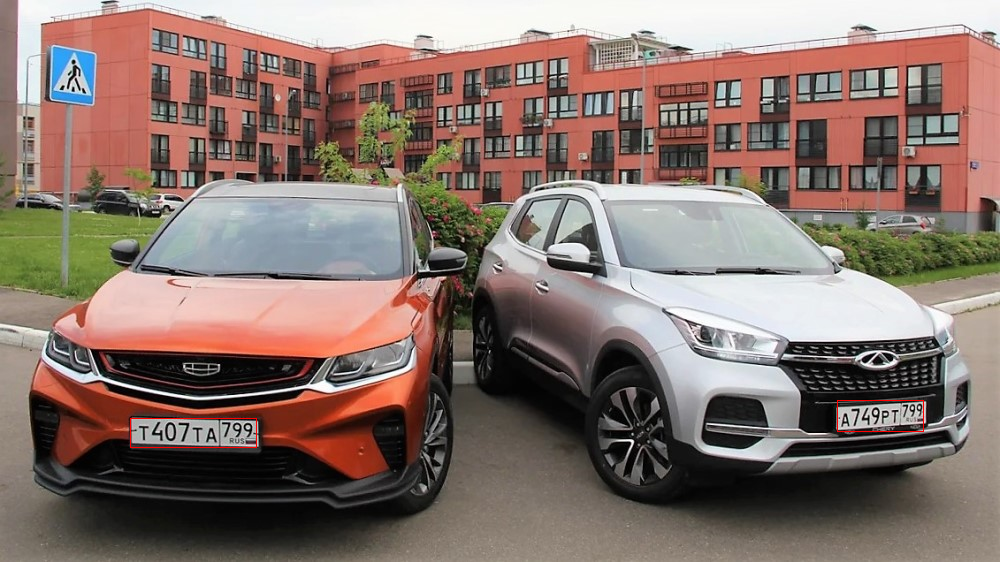

In [ ]:
cv2_imshow(image)

### Test on dataset

In [ ]:
%%capture
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

In [ ]:
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *
from utils import BBFormat

In [ ]:
import sys
sys.path.append('/content/Object-Detection-Metrics/lib')

In [ ]:
pnet_save_model_path = '/content/drive/MyDrive/task/licence_plate/pnet-09-38-49.pth'
onet_save_model_path = '/content/drive/MyDrive/task/licence_plate/onet-12-02-33.pth'
dataset_path = "/content/data"

with open('/content/drive/MyDrive/task/licence_plate/test_ann.json') as f:
    test_annotation = json.load(f)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_mtcnn = MtcnnNet(device, p_model_path=pnet_save_model_path, o_model_path=onet_save_model_path)

In [ ]:
allBoundingBoxes = BoundingBoxes()

bbFormat = BBFormat.XYX2Y2

for img_info in tqdm(test_annotation):
  image_gt = []
  image_preds = []
  
  for plate in img_info['nums']:
    bb = np.array(plate['box'])
    x1, y1, x2, y2 = min(bb[:, 0]), min(bb[:, 1]), max(bb[:, 0]), max(bb[:, 1])

    bb = BoundingBox(img_info["file"],
                     0,
                     x1,
                     y1,
                     x2,
                     y2,
                     CoordinatesType.Absolute,
                     (0, 0),
                     BBType.GroundTruth,
                     format=bbFormat)
    allBoundingBoxes.addBoundingBox(bb)


  image_path = f'{dataset_path}/{img_info["file"]}'
  image = cv2.imread(image_path)
  image = cv2.resize(image, (0, 0), fx = 1, fy = 1, interpolation=cv2.INTER_CUBIC)
  bboxes = test_mtcnn.predict(image, (50, 15))

  for bbox in bboxes:
    bb = BoundingBox(img_info["file"],
                    0,
                    bbox[0],
                    bbox[1],
                    bbox[2],
                    bbox[3],
                    CoordinatesType.Absolute,
                    (0, 0),
                    BBType.Detected,
                    bbox[4],
                    format=bbFormat)
    allBoundingBoxes.addBoundingBox(bb)

100%|██████████| 2564/2564 [04:23<00:00,  9.73it/s]


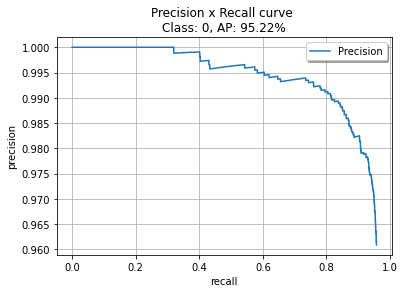

In [ ]:
savePath = '/content/'
iouThreshold = 0.5

evaluator = Evaluator()
acc_AP = 0
validClasses = 0

# Plot Precision x Recall curve
detections = evaluator.PlotPrecisionRecallCurve(
    allBoundingBoxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=iouThreshold,  # IOU threshold
    method=MethodAveragePrecision.EveryPointInterpolation,
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=False,  # Don't plot the interpolated precision curve
    savePath=savePath,
    showGraphic=True)

In [ ]:
f = open(os.path.join(savePath, 'results.txt'), 'w')
f.write('Object Detection Metrics\n')
f.write('https://github.com/rafaelpadilla/Object-Detection-Metrics\n\n\n')
f.write('Average Precision (AP), Precision and Recall per class:')

# each detection is a class
for metricsPerClass in detections:
    # Get metric values per each class
    cl = metricsPerClass['class']
    ap = metricsPerClass['AP']
    precision = metricsPerClass['precision']
    recall = metricsPerClass['recall']
    totalPositives = metricsPerClass['total positives']
    total_TP = metricsPerClass['total TP']
    total_FP = metricsPerClass['total FP']

    if totalPositives > 0:
        validClasses = validClasses + 1
        acc_AP = acc_AP + ap
        prec = ['%.2f' % p for p in precision]
        rec = ['%.2f' % r for r in recall]
        ap_str = "{0:.2f}%".format(ap * 100)
        # ap_str = "{0:.4f}%".format(ap * 100)
        print('AP: %s (%s)' % (ap_str, cl))
        f.write('\n\nClass: %s' % cl)
        f.write('\nAP: %s' % ap_str)
        f.write('\nPrecision: %s' % prec)
        f.write('\nRecall: %s' % rec)

mAP = acc_AP / validClasses
mAP_str = "{0:.2f}%".format(mAP * 100)
print('mAP: %s' % mAP_str)
f.write('\n\n\nmAP: %s' % mAP_str)

AP: 95.22% (0)
mAP: 95.22%


14

# LPRNET

In [ ]:
part_save_txt = '/content/train/lprnet/'

## Prepare dataset

In [ ]:
from tqdm import tqdm
from imutils import paths
import numpy as np
import cv2
import os
import math
import json
import argparse
import random


In [ ]:
annotation_path = "/content/data/train.json"
dataset_path = "/content/data"

with open(annotation_path) as f:
    annotation = json.load(f)

In [ ]:
cannotation = annotation.copy()
random.shuffle(cannotation)

test_num = math.ceil(len(cannotation)*0.1)
test_annotation = cannotation[:test_num]
train_annotatoin = cannotation[test_num:]

In [ ]:
save_dir_train = "/content/train/lprnet/train"
save_dir_val = "/content/train/lprnet/val"

In [ ]:
!rm -rf $save_dir_train
!rm -rf $save_dir_val

In [ ]:
if not os.path.exists(save_dir_train):
    os.makedirs(save_dir_train)
if not os.path.exists(save_dir_val):
    os.makedirs(save_dir_val)

In [ ]:
r2e = {
 'А':'A',
 'В':'B',
 'Е':'E',
 'К':'K',
 'М':'M',
 'Н':'H',
 'О':'O',
 'Р':'P',
 'С':'C',
 'Т':'T',
 'У':'Y',
 'Х':'X'
}

In [ ]:
alp = set()

idx = 0
idx_train = 0
idx_val = 0

for img_info in tqdm(train_annotatoin):
    im_path = f'{dataset_path}/{img_info["file"]}'
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)

    img = cv2.imread(im_path)
    if img is None:
      continue
    nums = len(img_info['nums'])
    for i, plate in enumerate(img_info['nums']):
      idx += 1
      lb = plate['text']
      if len(lb) == 8:
        lb += '-'
      lb = lb.upper()
      for r, e in r2e.items():
        lb = lb.replace(r, e)
      for c in lb:
        alp.add(c)

      bb = np.array(plate['box'])
      x1, y1, x2, y2 = min(bb[:, 0]), min(bb[:, 1]), max(bb[:, 0]), max(bb[:, 1])
      x1 = max(0, x1)
      y1 = max(0, y1)
      x2 = min(x2, img.shape[1])
      y2 = min(y2, img.shape[0])
      
      w = int(x2 - x1 + 1.0)
      h = int(y2 - y1 + 1.0)

      img_crop = np.zeros((h, w, 3))
      img_crop = img[y1:y2+1, x1:x2+1, :]

      if idx % 10 == 0:
        save = save_dir_val+'/'+lb+suffix 
        try:
          cv2.imwrite(save, img_crop)
        except Exception as e:
          print(im_path, img.shape)
          print(x1, y1, x2, y2)  
        idx_val += 1
      else:
        save = save_dir_train+'/'+lb+suffix      
        try:
          cv2.imwrite(save, img_crop)
        except Exception as e:
          print(im_path, img.shape)
          print(x1, y1, x2, y2)
        idx_train += 1
  
print('image data processing done, write %d training images, %d val images' % (idx_train, idx_val))

100%|██████████| 23069/23069 [06:40<00:00, 57.57it/s]

image data processing done, write 21708 training images, 2412 val images


In [ ]:
alp

{'-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'E',
 'H',
 'K',
 'M',
 'O',
 'P',
 'T',
 'X',
 'Y'}

## Model (LPRNET)

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=256+class_num+128+64, out_channels=self.class_num, kernel_size=(1,1), stride=(1,1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)

        return logits

## Model (STNet)

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [ ]:
class STNet(nn.Module):
    
    def __init__(self):
        super(STNet, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(32, 32, kernel_size=5),
                nn.MaxPool2d(3, stride=3),
                nn.ReLU(True)
                )
        # Regressor for the 3x2 affine matrix
        self.fc_loc = nn.Sequential(
                nn.Linear(32 * 14 * 2, 32),
                nn.ReLU(True),
                nn.Linear(32, 3*2)
                )
        # Initialize the weights/bias with identity transformation 
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0], dtype=torch.float))
        
    def forward(self, x):
        
        xs = self.localization(x)
        xs = xs.view(-1, 32*14*2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1,2,3)
        
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        
        return x
    
if __name__ == "__main__":
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = STNet().to(device)
    
    input = torch.Tensor(2, 3, 24, 94).to(device)
    output = model(input)
    print('output shape is', output.shape)

output shape is torch.Size([2, 3, 24, 94])


## Dataloader

In [ ]:
import torch
from torch.utils.data import *
from imutils import paths
import numpy as np
import random
import cv2
import os

CHARS = ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
         'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y']

CHARS_DICT = {char:i for i, char in enumerate(CHARS)}

class LPRDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, PreprocFun=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        random.shuffle(self.img_paths)
        self.img_size = imgSize

        if PreprocFun is not None:
            self.PreprocFun = PreprocFun
        else:
            self.PreprocFun = self.transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        filename = self.img_paths[index]
        Image = cv2.imread(filename)
        height, width, _ = Image.shape
        if height != self.img_size[1] or width != self.img_size[0]:
            Image = cv2.resize(Image, self.img_size)
        Image = self.PreprocFun(Image)

        basename = os.path.basename(filename)
        imgname, suffix = os.path.splitext(basename)
        if (imgname[-1] == '-'):
          imgname = imgname[:-1]
        label = list()
        for c in imgname:
            label.append(CHARS_DICT[c])
        # print(label)
        # assert len(label) == 9, f'label'
        return Image, label, len(label)

    def transform(self, img):
        img = img.astype('float32')
        img -= 127.5
        img *= 0.0078125
        img = np.transpose(img, (2, 0, 1))

        return img

def collate_fn(batch):
    imgs = []
    labels = []
    lengths = []
    for _, sample in enumerate(batch):
        img, label, length = sample
        imgs.append(torch.from_numpy(img))
        labels.extend(label)
        lengths.append(length)
    labels = np.asarray(labels).flatten().astype(np.float32)

    return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

## Utils

In [ ]:
def decode(preds, CHARS):
    # greedy decode
    pred_labels = list()
    labels = list()
    for i in range(preds.shape[0]):
        pred = preds[i, :, :]
        pred_label = list()
        for j in range(pred.shape[1]):
            pred_label.append(np.argmax(pred[:, j], axis=0))
        no_repeat_blank_label = list()
        pre_c = pred_label[0]
        no_repeat_blank_label.append(pre_c)
        for c in pred_label: # dropout repeate label and blank label
            if (pre_c == c) or (c == len(CHARS) - 1):
                if c == len(CHARS) - 1:
                    pre_c = c
                continue
            no_repeat_blank_label.append(c)
            pre_c = c
        pred_labels.append(no_repeat_blank_label)
        
    for i, label in enumerate(pred_labels):
        lb = ""
        for j in label:
            lb += CHARS[j]
        labels.append(lb)
    
    return labels, pred_labels

def eval(lprnet, STN, dataloader, dataset, device):
    lprnet = lprnet.to(device)
    STN = STN.to(device)
    TP = 0
    for imgs, labels, lengths in dataloader:   # img: torch.Size([2, 3, 24, 94])  # labels: torch.Size([14]) # lengths: [7, 7] (list)
        imgs, labels = imgs.to(device), labels.to(device)
        transfer = STN(imgs)
        logits = lprnet(transfer) # torch.Size([batch_size, CHARS length, output length ])
    
        preds = logits.cpu().detach().numpy()  # (batch size, 68, 18)
        _, pred_labels = decode(preds, CHARS)  # list of predict output
        # print(pred_labels)
        start = 0
        for i, length in enumerate(lengths):
            label = labels[start:start+length]
            start += length
            if np.array_equal(np.array(pred_labels[i]), label.cpu().numpy()):
                TP += 1
            
    ACC = TP / len(dataset) 
    
    return ACC

## Train model 

In [257]:
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import argparse
import time
import copy
from datetime import datetime

In [ ]:
def sparse_tuple_for_ctc(T_length, lengths):
    input_lengths = []
    target_lengths = []

    for ch in lengths:
        input_lengths.append(T_length)
        target_lengths.append(ch)

    return tuple(input_lengths), tuple(target_lengths)

In [ ]:
img_size = (94, 24)
img_dirs_train = "/content/train/lprnet/train"
img_dirs_val = "/content/train/lprnet/val"
dropout_rate = 0.5
num_epoch = 33
batch_size = 128

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
lprnet = LPRNet(class_num=len(CHARS), dropout_rate=dropout_rate)
lprnet.to(device)
print("LPRNet loaded")

LPRNet loaded


In [ ]:
STN = STNet()
STN.to(device)
print("STN loaded")

STN loaded


In [ ]:
dataset = {'train': LPRDataLoader([img_dirs_train], img_size),
           'val': LPRDataLoader([img_dirs_val], img_size)}

dataloader = {'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn),
              'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)}
print('training dataset loaded with length : {}'.format(len(dataset['train'])))
print('validation dataset loaded with length : {}'.format(len(dataset['val'])))

training dataset loaded with length : 19594
validation dataset loaded with length : 2382


In [ ]:
# define optimizer & loss
optimizer = torch.optim.Adam([{'params': STN.parameters(), 'weight_decay': 2e-5},
                              {'params': lprnet.parameters()}])
ctc_loss = nn.CTCLoss(blank=len(CHARS)-1, reduction='mean') # reduction: 'none' | 'mean' | 'sum'

In [ ]:
## save logging and weights
train_logging_file = '/content/train/lprnet/train_logging.txt'
validation_logging_file = '/content/train/lprnet/validation_logging.txt'
save_dir = '/content/train/lprnet/saving_ckpt'

if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [ ]:
start_time = time.time()
total_iters = 0
best_acc = 0.0
T_length = 18 # args.lpr_max_len

print('training kicked off..')
print('-' * 10) 
for epoch in range(num_epoch):
    # train model
    lprnet.train()
    STN.train()
    since = time.time()
    for imgs, labels, lengths in dataloader['train']:   # img: torch.Size([2, 3, 24, 94])  # labels: torch.Size([14]) # lengths: [7, 7] (list)
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            # print(len(labels), len(lengths))
            # print(imgs.shape)
            transfer = STN(imgs)
            # print(transfer.shape)
            logits = lprnet(transfer)  # torch.Size([batch_size, CHARS length, output length ])
            # print(logits.shape)
            
            log_probs = logits.permute(2, 0, 1) # for ctc loss: length of output x batch x length of chars
            # print(log_probs.shape)
            log_probs = log_probs.log_softmax(2).requires_grad_()  
            # print(log_probs.shape)
            input_lengths, target_lengths = sparse_tuple_for_ctc(T_length, lengths) # convert to tuple with length as batch_size 
            # print(log_probs, labels)
            loss = ctc_loss(log_probs, labels, input_lengths=input_lengths, target_lengths=target_lengths)
            loss.backward()
            optimizer.step()
            
            total_iters += 1
            # print train information
            if total_iters % 100 == 0:
                # current training accuracy             
                preds = logits.cpu().detach().numpy()  # (batch size, 68, 18)
                _, pred_labels = decode(preds, CHARS)  # list of predict output
                total = preds.shape[0]
                start = 0
                TP = 0
                for i, length in enumerate(lengths):
                    label = labels[start:start+length]
                    start += length
                    print(np.array(pred_labels[i]), label.cpu().numpy())
                    if np.array_equal(np.array(pred_labels[i]), label.cpu().numpy()):
                        TP += 1
                
                time_cur = (time.time() - since) / 100
                since = time.time()
                
                for p in  optimizer.param_groups:
                    lr = p['lr']
                if (total_iters % 100 == 0):
                  print("Epoch {}/{}, Iters: {:0>6d}, loss: {:.4f}, train_accuracy: {:.4f}, time: {:.2f} s/iter, learning rate: {}"
                        .format(epoch, num_epoch-1, total_iters, loss.item(), TP/total, time_cur, lr))
                with open(train_logging_file, 'a') as f:
                    f.write("Epoch {}/{}, Iters: {:0>6d}, loss: {:.4f}, train_accuracy: {:.4f}, time: {:.2f} s/iter, learning rate: {}"
                      .format(epoch, num_epoch-1, total_iters, loss.item(), TP/total, time_cur, lr)+'\n')
                f.close()
 
        if total_iters % 1000 == 0:
            torch.save({
                'iters': total_iters,
                'net_state_dict': lprnet.state_dict()},
                os.path.join(save_dir, 'lprnet_Iter_%06d_model.ckpt' % total_iters))
            
            torch.save({
                'iters': total_iters,
                'net_state_dict': STN.state_dict()},
                os.path.join(save_dir, 'stn_Iter_%06d_model.ckpt' % total_iters))

    lprnet.eval()
    STN.eval()
 
    ACC = eval(lprnet, STN, dataloader['val'], dataset['val'], device)
                
    if best_acc <= ACC:
        best_acc = ACC
        best_iters = total_iters
        lprnet_best_model_wts = copy.deepcopy(lprnet.state_dict())
        stn_best_model_wts = copy.deepcopy(STN.state_dict())
    
    print("Epoch {}/{}, Iters: {:0>6d}, validation_accuracy: {:.4f}".format(epoch, num_epoch-1, total_iters, ACC))
    print()
    with open(validation_logging_file, 'a') as f:
        f.write("Epoch {}/{}, Iters: {:0>6d}, validation_accuracy: {:.4f}".format(epoch, num_epoch-1, total_iters, ACC)+'\n')
    f.close()
    
    lprnet.train()
    STN.train()
                            
time_elapsed = time.time() - start_time  
print('Finally Best Accuracy: {:.4f} in iters: {}'.format(best_acc, best_iters))
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [253]:
lprnet_best_model_wts = copy.deepcopy(lprnet.state_dict())
stn_best_model_wts = copy.deepcopy(STN.state_dict())


## Save model

In [304]:
lprnet.load_state_dict(lprnet_best_model_wts)

date_time = datetime.now()
lprnet_save_model_path = date_time.strftime(f"/content/train/lprnet/lprnet-%H-%M-%S.pth")

torch.save(lprnet.state_dict(), lprnet_save_model_path)

In [306]:
!cp $lprnet_save_model_path /content/drive/MyDrive/task/licence_plate

In [305]:
STN.load_state_dict(stn_best_model_wts)

date_time = datetime.now()
stn_save_model_path = date_time.strftime(f"/content/train/lprnet/stn-%H-%M-%S.pth")

torch.save(STN.state_dict(), stn_save_model_path)

In [307]:
!cp $stn_save_model_path /content/drive/MyDrive/task/licence_plate

## Test model

### Prepare test data

In [281]:
import json
with open('/content/drive/MyDrive/task/licence_plate/lprnet_test_ann.json', 'w') as f:
    json.dump(test_annotation, f)

In [283]:
test_annotation_path = '/content/drive/MyDrive/task/licence_plate/lprnet_test_ann.json'

with open(test_annotation_path) as f:
    test_annotation = json.load(f)

[{'nums': [{'box': [[348, 679], [625, 683], [623, 742], [348, 735]], 'text': 'P967HT54'}], 'file': 'train/2402.jpg'}, {'nums': [{'box': [[384, 361], [607, 365], [611, 406], [384, 404]], 'text': 'P002KB47'}], 'file': 'train/247.jpg'}, {'nums': [{'box': [[635, 353], [714, 352], [716, 370], [638, 371]], 'text': 'H001MK36'}], 'file': 'train/16580.jpg'}, {'nums': [{'box': [[418, 574], [565, 562], [569, 608], [424, 621]], 'text': 'H005TP98'}], 'file': 'train/23489.jpg'}, {'nums': [{'box': [[163, 378], [338, 380], [338, 421], [163, 415]], 'text': 'K485MH154'}], 'file': 'train/6562.jpg'}, {'nums': [{'box': [[167, 204], [289, 199], [289, 223], [163, 227]], 'text': 'O190HY178'}], 'file': 'train/7618.bmp'}, {'nums': [{'box': [[821, 695], [1081, 672], [1077, 724], [825, 753]], 'text': 'B600CK150'}], 'file': 'train/13155.jpg'}, {'nums': [{'box': [[257, 241], [384, 232], [390, 258], [260, 271]], 'text': 'B594YX35'}], 'file': 'train/6091.bmp'}, {'nums': [{'box': [[1137, 380], [1356, 371], [1361, 428]

In [285]:
dataset_path = "/content/data"
save_dir_test = "/content/train/lprnet/test"

if not os.path.exists(save_dir_test):
    os.makedirs(save_dir_test)

In [286]:
for img_info in tqdm(test_annotation):
    im_path = f'{dataset_path}/{img_info["file"]}'
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)

    img = cv2.imread(im_path)
    if img is None:
      continue
    nums = len(img_info['nums'])
    for i, plate in enumerate(img_info['nums']):
      idx += 1
      lb = plate['text']
      if len(lb) == 8:
        lb += '-'
      lb = lb.upper()
      for r, e in r2e.items():
        lb = lb.replace(r, e)
      for c in lb:
        alp.add(c)

      bb = np.array(plate['box'])
      x1, y1, x2, y2 = min(bb[:, 0]), min(bb[:, 1]), max(bb[:, 0]), max(bb[:, 1])
      x1 = max(0, x1)
      y1 = max(0, y1)
      x2 = min(x2, img.shape[1])
      y2 = min(y2, img.shape[0])
      
      w = int(x2 - x1 + 1.0)
      h = int(y2 - y1 + 1.0)

      img_crop = np.zeros((h, w, 3))
      img_crop = img[y1:y2+1, x1:x2+1, :]

      save = save_dir_test+'/'+lb+suffix      
      try:
        cv2.imwrite(save, img_crop)
      except Exception as e:
        print(im_path, img.shape)
        print(x1, y1, x2, y2)
  
print('image data processing done, write %d test images' % (idx))

100%|██████████| 2564/2564 [00:46<00:00, 55.63it/s]

image data processing done, write 26806 test images


In [262]:
import torchvision
import matplotlib.pyplot as plt

In [287]:
import torch
from torch.utils.data import *
from imutils import paths
import numpy as np
import random
import cv2
import os

CHARS = ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
         'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y']

CHARS_DICT = {char:i for i, char in enumerate(CHARS)}

class LPRDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, PreprocFun=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        random.shuffle(self.img_paths)
        self.img_size = imgSize

        if PreprocFun is not None:
            self.PreprocFun = PreprocFun
        else:
            self.PreprocFun = self.transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        filename = self.img_paths[index]
        Image = cv2.imread(filename)
        height, width, _ = Image.shape
        if height != self.img_size[1] or width != self.img_size[0]:
            Image = cv2.resize(Image, self.img_size)
        Image = self.PreprocFun(Image)

        basename = os.path.basename(filename)
        imgname, suffix = os.path.splitext(basename)
        if (imgname[-1] == '-'):
          imgname = imgname[:-1]
        label = list()
        for c in imgname:
            label.append(CHARS_DICT[c])
        # print(label)
        # assert len(label) == 9, f'label'
        return Image, label, len(label)

    def transform(self, img):
        img = img.astype('float32')
        img -= 127.5
        img *= 0.0078125
        img = np.transpose(img, (2, 0, 1))

        return img

### Run model

100%|██████████| 2634/2634 [00:18<00:00, 139.37it/s]


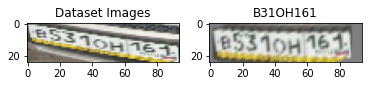

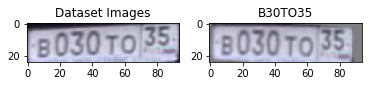

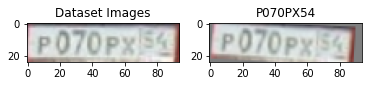

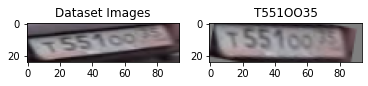

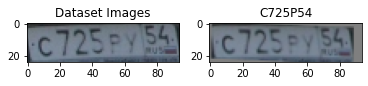

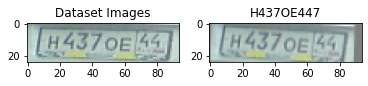

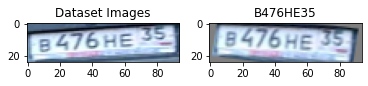

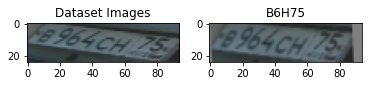

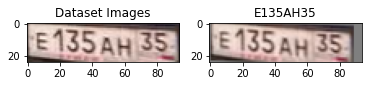

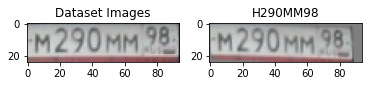

In [294]:
img_dirs = "/content/train/lprnet/test"

def convert_image(inp):
    # convert a Tensor to numpy image
    inp = inp.numpy().transpose((1,2,0))
    inp = 127.5 + inp/0.0078125
    inp = inp.astype('uint8') 
    inp = inp[:,:,::-1]
    return inp

dataset = LPRDataLoader([img_dirs], img_size)   
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn) 

tp = 0

with torch.no_grad():
    # Get a batch of training data
    for i, item in enumerate(tqdm(dataloader)):
      imgs, labels, lengths = item
      
      input_tensor = imgs.cpu()
      
      transfer = STN(imgs.to(device))
      transformed_input_tensor = transfer.cpu()
      
      logits = lprnet(transfer) # torch.Size([batch_size, CHARS length, output length ])
  
      preds = logits.cpu().detach().numpy()  # (batch size, 68, 18)
      _, pred_labels = decode(preds, CHARS)  # list of predict output

      start = 0
      for j, length in enumerate(lengths):
          label = labels[start:start+length]
          start += length
          if np.array_equal(np.array(pred_labels[j]), label.cpu().numpy()):
              tp += 1
      
      if (i < 10):
        in_grid = convert_image(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image(torchvision.utils.make_grid(transformed_input_tensor))

        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)

        pred_number = ""
        for label in pred_labels[0]:
          pred_number += CHARS[label]
        axarr[1].set_title(pred_number)

In [295]:
print(f"Accuracy given model {tp/len(dataloader)}")

Accuracy given model 0.6917236142748672


# Demo all pipeline

In [315]:
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw, ImageFont

In [301]:
pnet_save_model_path = '/content/drive/MyDrive/task/licence_plate/pnet-09-38-49.pth'
onet_save_model_path = '/content/drive/MyDrive/task/licence_plate/onet-12-02-33.pth'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [310]:
test_mtcnn = MtcnnNet(device, p_model_path=pnet_save_model_path, o_model_path=onet_save_model_path)

In [ ]:
lprnet_save_model_path = '/content/drive/MyDrive/task/licence_plate/lprnet-13-46-01.pth'

CHARS = ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
         'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y']

CHARS_DICT = {char:i for i, char in enumerate(CHARS)}

lprnet = LPRNet(class_num=len(CHARS), dropout_rate=0.5)
lprnet.to(device)
lprnet.load_state_dict(torch.load(lprnet_save_model_path, map_location=lambda storage, loc: storage))
lprnet.eval()

In [ ]:
stn_save_model_path = '/content/drive/MyDrive/task/licence_plate/stn-13-46-11.pth'

STN = STNet()
STN.to(device)
STN.load_state_dict(torch.load(stn_save_model_path, map_location=lambda storage, loc: storage))
STN.eval()

In [318]:
def cv2ImgAddText(img, text, pos, textColor=(255, 0, 0), textSize=12):
    if (isinstance(img, np.ndarray)):  # detect opencv format or not
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    fontText = ImageFont.truetype("/content/drive/MyDrive/task/licence_plate/NotoSansCJK-Regular.ttc", textSize, encoding="utf-8")
    draw.text(pos, text, textColor, font=fontText)

    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)

In [337]:
def predict(image, debug=True):
  image = cv2.resize(image,  (0, 0), fx = 1, fy = 1, interpolation=cv2.INTER_CUBIC)
  since = time.time()
  bboxes = test_mtcnn.predict(image, (50, 15))

  for i in range(bboxes.shape[0]):
      bbox = bboxes[i, :4]
      x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
      w = int(x2 - x1 + 1.0)
      h = int(y2 - y1 + 1.0)
      img_box = np.zeros((h, w, 3))
      img_box = image[y1:y2+1, x1:x2+1, :]
      im = cv2.resize(img_box, (94, 24), interpolation=cv2.INTER_CUBIC)
      im = (np.transpose(np.float32(im), (2, 0, 1)) - 127.5)*0.0078125
      data = torch.from_numpy(im).float().unsqueeze(0).to(device)  # torch.Size([1, 3, 24, 94]) 
      transfer = STN(data)
      preds = lprnet(transfer)
      preds = preds.cpu().detach().numpy()  # (1, 68, 18)    
      labels, pred_labels = decode(preds, CHARS)

      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 1)
      image = cv2ImgAddText(image, labels[0], (x1, y1-12), textColor=(255, 255, 0), textSize=15)
  if debug:
    print("model inference in {:2.3f} seconds".format(time.time() - since))      
  image = cv2.resize(image, (0, 0), fx = 1, fy = 1, interpolation=cv2.INTER_CUBIC)
  return image

In [ ]:
date_time = datetime.now()
video_save_path = date_time.strftime(f"/content/demo-%H-%M-%S.pth")

model inference in 0.113 seconds


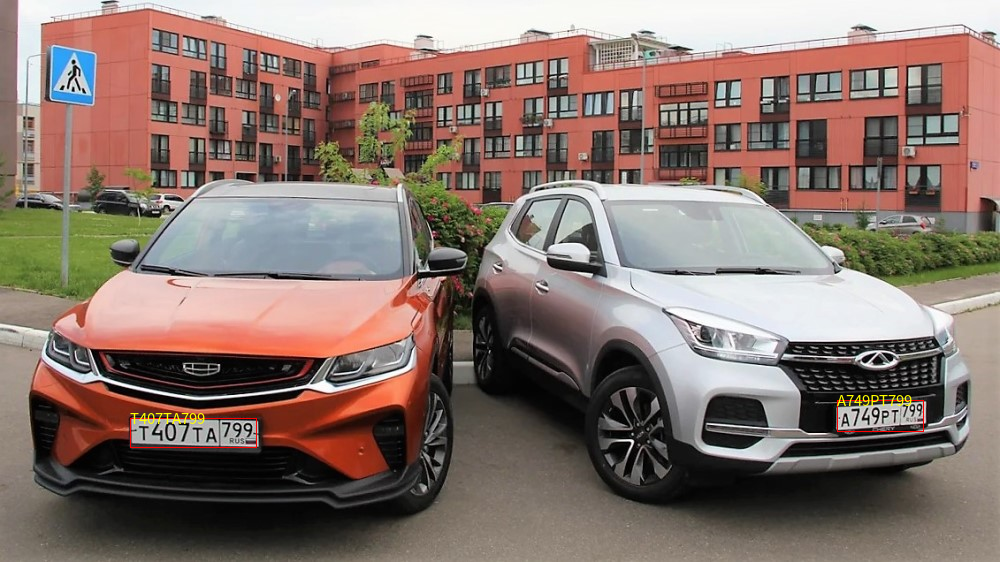

In [325]:
image_path = '/content/drive/MyDrive/task/licence_plate/two_car.jpg'

since = time.time()
image = cv2.imread(image_path)
result = predict(image)
cv2_imshow(result)

In [338]:
vid_capture = cv2.VideoCapture('/content/drive/MyDrive/task/licence_plate/test_video.mp4')

width = int(vid_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
length = int(vid_capture.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(vid_capture.get(cv2.CAP_PROP_FPS))

print(fps, width, height)

date_time = datetime.now()
video_save_path = date_time.strftime(f"/content/demo-%H-%M-%S.mp4")

output = cv2.VideoWriter(video_save_path, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width, height))

while(vid_capture.isOpened()):
  ret, frame = vid_capture.read()
  if ret == True:
    result = predict(frame, debug=False)
    output.write(frame)
  else:
    break

vid_capture.release()
output.release()


29 1920 1080


In [344]:
!cp $video_save_path /content/drive/MyDrive/task/licence_plate

In [341]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_save_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)